# 1. Install Dependencies and Setup

In [7]:
# Import libraries for data analysis and visualization
import cv2
import os

import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import  Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from keras.models import load_model


In [6]:
data_dir = 'unprocessedDataset' 
for image_class in os.listdir(data_dir): 
    print(image_class)


Training
Testing


## Preprocessing function

In [34]:
# convert and resize directly while using  a data generator in one step

#target_size=(256,256) 


def grayscale_to_rgb_resize(image, target_size=(256,256)):
    # Check if the image is grayscale (single channel)
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        # Replicate the grayscale channel across all three RGB channels
        rgb_image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    elif len(image.shape) == 3 and image.shape[2] == 3:
        # Image is already RGB
        rgb_image = image
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or RGB.")

    # Resize the image to the target size
    resized_image = cv2.resize(rgb_image, (target_size[1], target_size[0]))

    return resized_image




## Getting the data using generators

In [35]:
# Data preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=grayscale_to_rgb_resize,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.05  
    )



test_datgen = ImageDataGenerator(preprocessing_function=grayscale_to_rgb_resize, 
                                 rescale=1./255)


batch_size=32
im_dim = (256,256)



train_generator = train_datagen.flow_from_directory(
    'Training',
    target_size=im_dim,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'Training',                      
    target_size=im_dim,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


test_generator = test_datgen.flow_from_directory(
    'Testing',                      #                               
    target_size=im_dim,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)




Found 5429 images belonging to 4 classes.
Found 283 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


#  Build Deep Learning Model

In [11]:
# Load pre-trained InceptionResNetV2 model without top classification layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256,256, 3))

num_classes=4

# Add new classification layers
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(512, kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  
x = Dropout(0.5)(x)

x = Dense(128, kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  
x = Dropout(0.25)(x)

predictions = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in the dataset

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 55,189,860 (210.53 MB)

 Trainable params: 55,129,316 (210.30 MB)

 Non-trainable params: 60,544 (236.50 KB)

# Callbacks

In [13]:
#Creating a directory where to store the trained model
from datetime import datetime

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Combining the prefix with the timestamp generated by datetime.now().strftime() 

tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir) 

In [14]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # Quantity to be monitored for improvement
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

### Cross check before moving forward and running the model function

In [15]:
len(train_generator)

170

In [16]:
len(validation_generator)

9

In [17]:
print(tensorboard_callback)

In [18]:
print(early_stopping)

# Training

In [19]:
history=model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback, early_stopping])

Epoch 1/100


/Users/boubacartanda/neuefische/capstone_project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


170/170 ━━━━━━━━━━━━━━━━━━━━ 2174s 13s/step - accuracy: 0.7202 - loss: 7.0122 - val_accuracy: 0.8975 - val_loss: 4.4429
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 3679s 22s/step - accuracy: 0.9584 - loss: 3.7036 - val_accuracy: 0.8693 - val_loss: 3.1196
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4327s 25s/step - accuracy: 0.9752 - loss: 2.0046 - val_accuracy: 0.9470 - val_loss: 1.3429
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5503s 32s/step - accuracy: 0.9844 - loss: 1.0686 - val_accuracy: 0.9505 - val_loss: 1.2331
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 3702s 22s/step - accuracy: 0.9856 - loss: 0.6060 - val_accuracy: 0.9470 - val_loss: 0.8336
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2629s 15s/step - accuracy: 0.9883 - loss: 0.3629 - val_accuracy: 0.9647 - val_loss: 1.1228
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2464s 14s/step - accuracy: 0.9935 - loss: 0.2403 - val_accuracy: 0.9399 - val_loss: 0.4334
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2348s 14s/step - accuracy: 0.9909 - loss: 0.174

In [20]:
history.history

{'accuracy': [0.8613004088401794,
  0.9616872072219849,
  0.9736599922180176,
  0.9823172092437744,
  0.9865536689758301,
  0.9869220852851868,
  0.993368923664093,
  0.9917111992835999,
  0.9942899346351624,
  0.9930005669593811,
  0.9937373399734497,
  0.9955793023109436,
  0.9915269613265991,
  0.9959476590156555,
  0.995026707649231,
  0.9924479722976685,
  0.9942899346351624],
 'loss': [5.94541072845459,
  3.2115087509155273,
  1.7394810914993286,
  0.9358623027801514,
  0.5388834476470947,
  0.33291831612586975,
  0.21935135126113892,
  0.1624654233455658,
  0.1210879385471344,
  0.10624948143959045,
  0.09533093124628067,
  0.07601992040872574,
  0.08286920189857483,
  0.05991119518876076,
  0.06012100726366043,
  0.06642993539571762,
  0.055644337087869644],
 'val_accuracy': [0.8975265026092529,
  0.869257926940918,
  0.9469964504241943,
  0.9505300521850586,
  0.9469964504241943,
  0.9646643400192261,
  0.9399293065071106,
  0.9575971961021423,
  0.9540635943412781,
  0.936395

In [118]:
X_test = []
y_test = []

# No of batches from the test generator
batch_count = 0
max_batches = 41

for X_batch, y_batch in test_generator:
    X_test.append(X_batch)
    y_test.append(y_batch)
    batch_count += 1
    if batch_count >= max_batches:
        break

In [119]:
# Concatenate the lists into numpy arrays
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [120]:
X_test.shape

(1311, 256, 256, 3)

In [122]:
y_test

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [123]:
# Predict labels using the model
y_pred = model.predict(X_test).round() # rounding provides correct one-hot encoded values to match the labels obtained from the data_generator




41/41 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step


In [124]:
y_pred # As we can see, y_pred shows ones and zeros

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [125]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

class_labels = ['glioma', 'meningioma', 'no tumor', 'pituitary']
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

### Check test results: visualization by confusion matrix

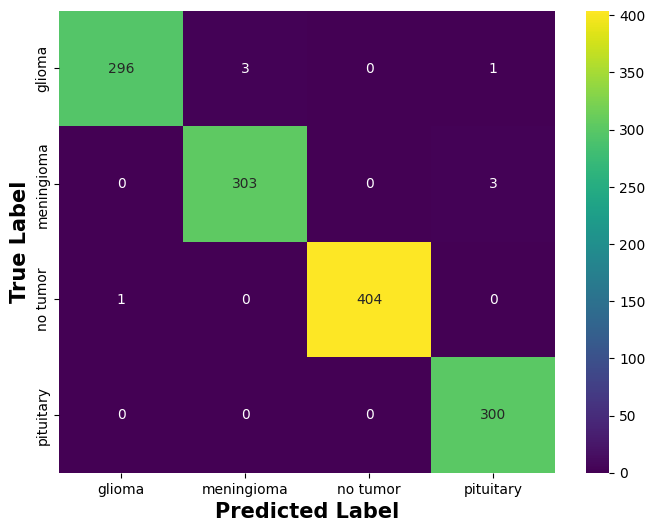

In [139]:
# Create a heatmap with annotations centered in the cells and a color scale
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix , annot=True, fmt="d", cmap="viridis", cbar=True,
            xticklabels=class_labels, yticklabels=class_labels, annot_kws={"ha": 'center', "va": 'center'})

plt.xlabel('Predicted Label', fontsize=15, fontweight='bold')
plt.ylabel('True Label', fontsize=15, fontweight='bold')
plt.show()

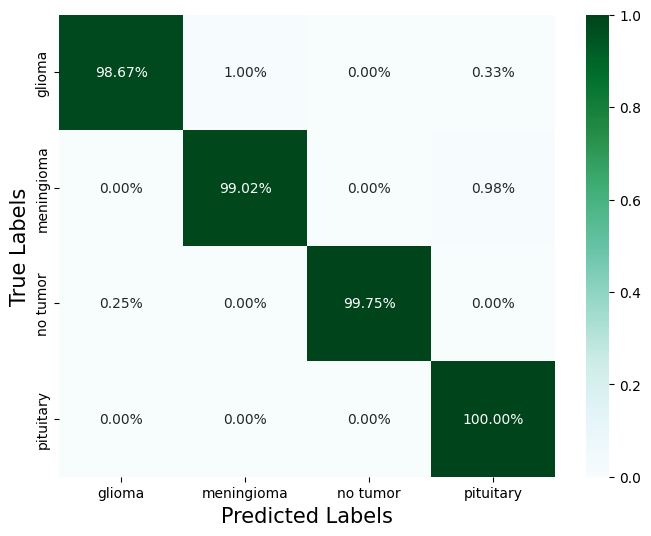

In [106]:
# Plot confusion matrix as a heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='BuGn', xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'], yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])

plt.xlabel("Predicted Labels", fontsize=15, color='black')
plt.ylabel("True Labels", fontsize=15, color='black')
plt.show()

### Print a classification report to observe a detailed performance report on metrics

In [144]:
report = classification_report(y_test, y_pred,  digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.997     0.987     0.992       300
           1      0.990     0.990     0.990       306
           2      1.000     0.998     0.999       405
           3      0.987     1.000     0.993       300

    accuracy                          0.994      1311
   macro avg      0.993     0.994     0.993      1311
weighted avg      0.994     0.994     0.994      1311



## Error Analysis

### Analyzing the 8 mis-classified images 

41/41 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step
Confusion Matrix:
 [[296   3   0   1]
 [  0 303   0   3]
 [  1   0 404   0]
 [  0   0   0 300]]
Misclassified indices: [107 235 259 268 453 456 597 710]


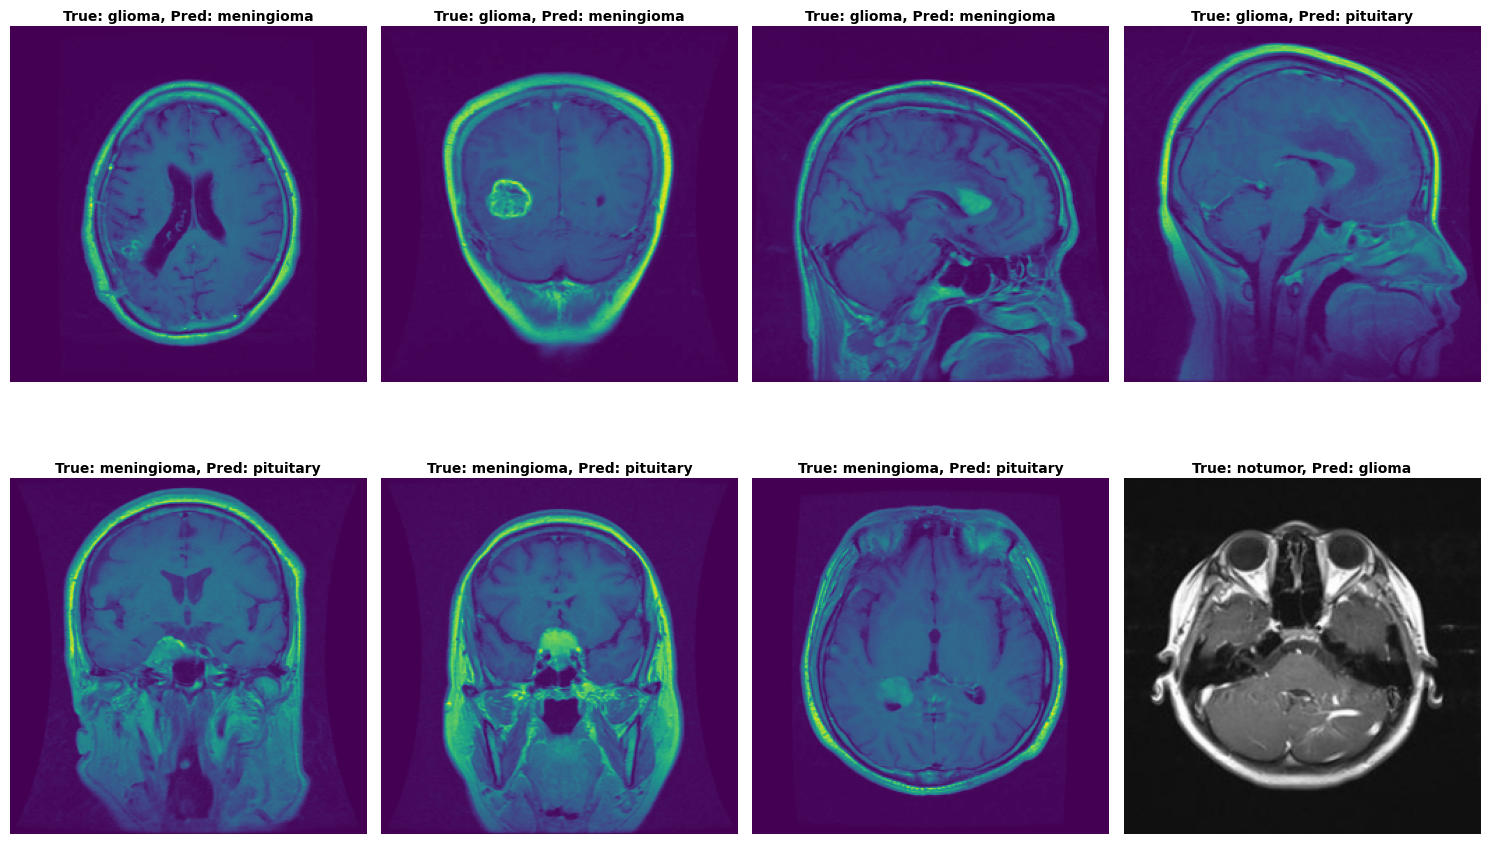

In [157]:
#Build a Pipeline

# Get the filenames and true labels
filenames = test_generator.filenames
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
num_samples = len(filenames)

# Make predictions
steps = int(np.ceil(num_samples / test_generator.batch_size))
y_pred = model.predict(test_generator, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Identify misclassified instances
misclassified_indices = np.where(y_pred_classes != y_true)[0]
print("Misclassified indices:", misclassified_indices)

# Plot misclassified images
num_images_to_plot = len(misclassified_indices)    

plt.figure(figsize=(15, 10))
for i, index in enumerate(misclassified_indices):
    plt.subplot(2, 4, i + 1)  # Use 2 rows and 4 columns for 8 images
    img_path = filenames[index]
    img = plt.imread(os.path.join('Testing', img_path))  # Correctly join the path Here Testing is the directory where the test images are stored
    img = cv2.resize(img, (256,256))
    plt.imshow(img)
    #plt.title(f"True: {class_labels[y_true[index]]}\nPred: {class_labels[y_pred_classes[index]]}")
    title = "True: {}, Pred: {}".format(class_labels[y_true[index]], class_labels[y_pred_classes[index]])
    plt.title(title, fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc='center', pad=4)
    
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Probabilistic Outputs :To inspect the prediction confidence and probabilistic outputs:

Image: glioma/Te-gl_0107.jpg
Class: glioma, Probability: 0.3277
Class: meningioma, Probability: 0.5126
Class: notumor, Probability: 0.0211
Class: pituitary, Probability: 0.1386


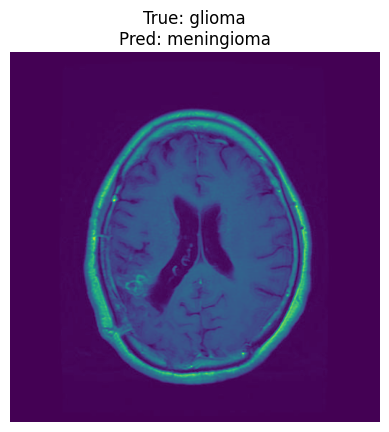

Image: glioma/Te-gl_0235.jpg
Class: glioma, Probability: 0.3312
Class: meningioma, Probability: 0.6407
Class: notumor, Probability: 0.0140
Class: pituitary, Probability: 0.0141


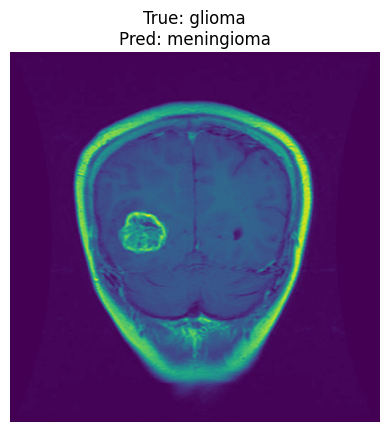

Image: glioma/Te-gl_0259.jpg
Class: glioma, Probability: 0.0038
Class: meningioma, Probability: 0.9922
Class: notumor, Probability: 0.0017
Class: pituitary, Probability: 0.0023


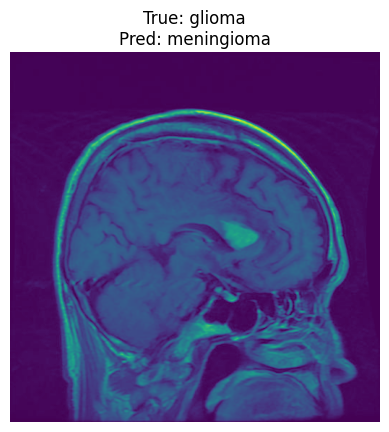

Image: glioma/Te-gl_0268.jpg
Class: glioma, Probability: 0.1080
Class: meningioma, Probability: 0.0110
Class: notumor, Probability: 0.0044
Class: pituitary, Probability: 0.8766


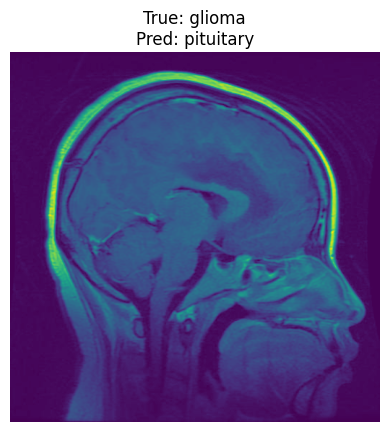

Image: meningioma/Te-me_0153.jpg
Class: glioma, Probability: 0.0144
Class: meningioma, Probability: 0.2068
Class: notumor, Probability: 0.0068
Class: pituitary, Probability: 0.7720


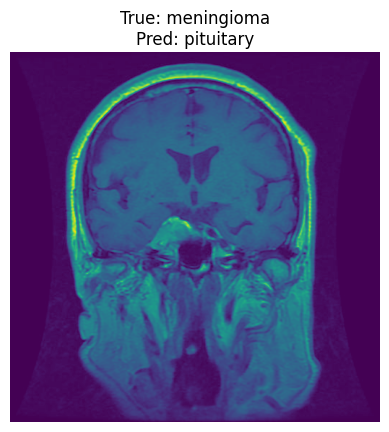

Image: meningioma/Te-me_0156.jpg
Class: glioma, Probability: 0.0037
Class: meningioma, Probability: 0.0068
Class: notumor, Probability: 0.0017
Class: pituitary, Probability: 0.9878


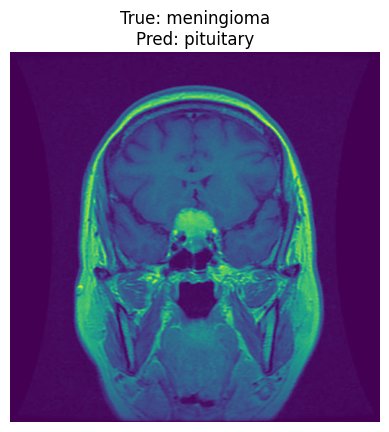

Image: meningioma/Te-me_0297.jpg
Class: glioma, Probability: 0.0150
Class: meningioma, Probability: 0.3270
Class: notumor, Probability: 0.0061
Class: pituitary, Probability: 0.6519


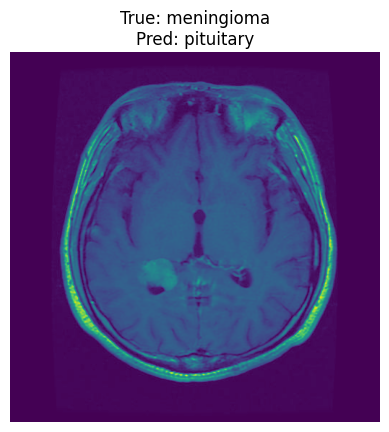

Image: notumor/Te-no_0104.jpg
Class: glioma, Probability: 0.4153
Class: meningioma, Probability: 0.0785
Class: notumor, Probability: 0.2020
Class: pituitary, Probability: 0.3042


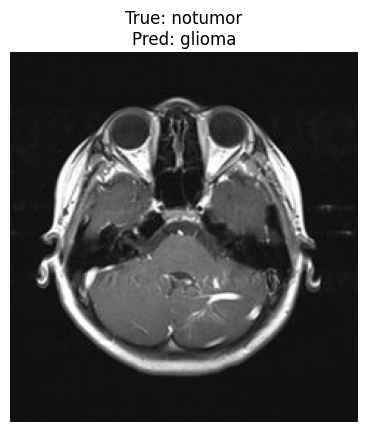

In [158]:
for i, index in enumerate(misclassified_indices):
    img_path = filenames[index]
    img = plt.imread(os.path.join('Testing', img_path))
    plt.imshow(img)
    plt.title(f"True: {class_labels[y_true[index]]}\nPred: {class_labels[y_pred_classes[index]]}")
    plt.axis('off')
    
    # Print probabilistic outputs
    probas = y_pred[index]
    print(f"Image: {img_path}")
    for class_label, proba in zip(class_labels, probas):
        print(f"Class: {class_label}, Probability: {proba:.4f}")
    plt.show()

# Plot Performance

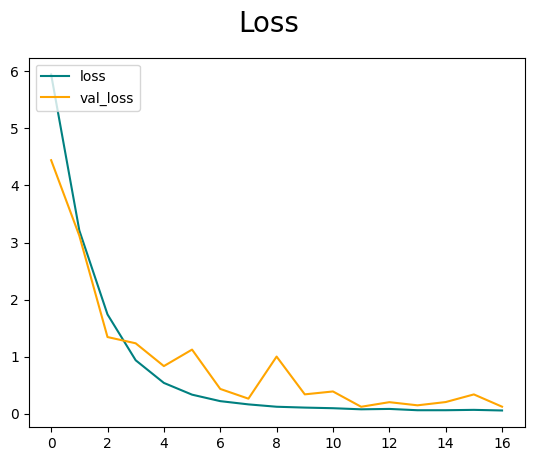

In [32]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

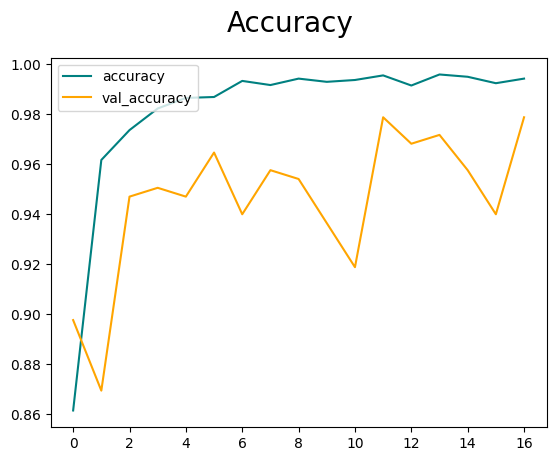

In [33]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Save the Model

In [44]:
keras.models.save_model(model, 'classification_model.keras')
